In [10]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn as sklearn
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier

import sklearn.preprocessing as preprocessing
from sklearn import linear_model
from sklearn import cross_validation
from sklearn.preprocessing import Imputer 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score

import datetime
from  datetime import timedelta

from subprocess import check_output

# import xgboost as xgb
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

https://www.kaggle.com/thepathofd/a-first-kaggle-part-1-forecasting-store-47

# 1 Import data

## 1.1 Read data
### 1.1.1 train

1. Train data: includes the target unit_sales by date, store_nbr, and item_nbr and a unique id;
2. Target unit_sales: integer or float; negative values represents returns of that particular ite; negative sales are treated at zero sales in the Test set.;
3. Onpromotion: for a specfied data and store_nbr; 16% of them are NaN.
4. date from 2013-01-01 to 2017-08-15

### 1.1.2 test

A possible way to forecast new product sales is using surrogates. That is finding similar products using **family** and **class attributes**, finding sales patterns in those similar products, possibly clustering those similar products and choosing the cluster with the best forecasting results.

From **2017-08-16 to 2017-08-31**

In [3]:
# split data
train_original = pd.read_csv("/Users/hanshany/Documents/USC/EE660/Final project/train_original.csv")
train_original['date'] = pd.to_datetime(train_original['date'])
train_8 = train_original[(train_original['date'].dt.month == 8) & (train_original['date'].dt.day > 15)]

/Users/hanshany/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
id             int64
date           object
store_nbr      int64
item_nbr       int64
unit_sales     float64
onpromotion    object
dtypes: float64(1), int64(3), object(2)
memory usage: 5.6+ GB


### 1.1.3 holidays_events

1. Transferred: a holiday is transferred officially falls on the calendar day, but was moved to another date by the government, which means a transferred day is more like a normal day than a holiday;
2. Type: additional, bridge, event, holiday, transfer, work day;
3. type-bridge: extra days added to a holiday; there are frequently made up by the type Work Day which is a day not normally scheduled for work that is meant to payback the Bridge.(调休……)
4. Locale: local, national, regional.

### 1.1.4 items

1. Item: family, class, perishable
2. NOTE: Items marked as perishable have a score weight of 1.25; otherwise, the weight is 1.0
3. There are 33 families class

### 1.1.5 oil

1. Ecuador is an oil-dependent country and it's economical heallth is highly vulnerable to shockc in oil prices.
2. **Training and testing data timeframe.**

### 1.1.6 stores

1. For the most part, stores in a particular cluster have one type.
2. One state can have many different store types.
3. Store: city, state, type and cluster;
4. Cluster: a grouping of similar stores.
5. Type: 5, cities: 22, states: 16.
6. Most of the store types seem to contain a mix of the clusters, especially with regards to store type "D". Only type "E" stores seem to fall within the single cluster of cluster 10. However with regards to our initial plan of trying to suss out relationships between store types and clusters, it seems that there is nothing apparent that stands out. If we think of store types, one would normally think of categories such as convenience store types, huge general store types or bulk buy types

### 1.1.7 transactions

1. Transactions: data, store_nbr
2. **Training** data timeframe

## 1.2 Low memory
Merge data
1. Join stores and items data to train data with respect to **store_nbr and item_nbr**
2. Join holiday and oil data to Train with respect to **date**

In [13]:
class Data(object):
    def __init__(self, data_folder, test_the_script=False, items_choice=None, holidays_choice=None):
        self.DATA_FOLDER = data_folder
        self.test_the_script = test_the_script
        self.items_choice = items_choice
        self.holidays_choice = holidays_choice
        self.read_data()
        # self.process_data()

        print('Train shape: ', self.train.shape)

    def read_data(self):
        self.nrows = None
#         if self.test_the_script:
#             self.nrows = 10000

        self.train = self.read_train_test_low_memory(train_flag = True)
        print("read train over~~")
        
        self.test = self.read_train_test_low_memory(train_flag = False)
        print("read test over~~")
        self.stores = self.read_stores_low_memory()
        self.items = self.read_items_low_memory()
        self.oil = self.read_oil_low_memory()
        self.transactions = self.read_transactions_low_memory()
        self.transactions_test = self.read_transactions_test_low_memory()
        self.holidays = self.read_holidays_low_memory()
        self.ma_unit_sales = self.read_ma_unit_sales_low_memory()
        self.ma_oil = self.read_ma_oil_low_memory()
        self.ma_transactions = self.read_ma_transactions_low_memory()
        print("read over~~")
        
        self.merged_train_data = self.merge_data(self.train, 'train', self.items_choice, self.holidays_choice)
        print("merge train over~~")

        self.merged_test_data = self.merge_data(self.test, 'test', self.items_choice, self.holidays_choice)
        print("merge test over~~")

        self.processed_train, self.processed_test = self.preprocessing_all(self.merged_train_data, self.merged_test_data)

            
    def read_train_test_low_memory(self, train_flag = True):
        filename = 'train'
        if not train_flag: 
            filename = 'test'

        types = {'id': 'int32',
                'item_nbr': 'int32',
                'store_nbr': 'int8',
                'unit_sales': 'float32',
                'onpromotion': bool,
            }
        data = pd.read_csv(self.DATA_FOLDER + filename + '.csv', parse_dates = ['date'], dtype = types, 
                        nrows = self.nrows, infer_datetime_format = True)
        
        data['onpromotion'].fillna(False, inplace = True)
        data['onpromotion'] = data['onpromotion'].map({False : 0, True : 1})
        data['onpromotion'] = data['onpromotion'].astype('int8')
        
        if train_flag:
            data.loc[(data.unit_sales < 0),'unit_sales'] = 0 
            data['unit_sales'] =  data['unit_sales'].apply(pd.np.log1p) 
            
        return data

    
    def read_stores_low_memory(self):
        types = {'cluster': 'int8',
                'store_nbr': 'int8',
                }
        data = pd.read_csv(self.DATA_FOLDER + 'stores.csv', dtype = types)
        return data

    
    def read_items_low_memory(self):
        types = {'item_nbr': 'int32',
                'perishable': 'int8',
                'class' : 'int16'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'items.csv', dtype = types)
        return data  

    
    def read_oil_low_memory(self):
        types = {'dcoilwtico': 'float32',
                }
        data = pd.read_csv(self.DATA_FOLDER + 'oil.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True)
        return data
    
    
    def read_transactions_low_memory(self):
        types = {'transactions': 'float16',
                'store_nbr' : 'int8'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'transactions_all.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True)
        return data
    
    
    def read_transactions_test_low_memory(self):
        types = {'transactions': 'float16',
                 'store_nbr' : 'int8',
                 'mais_transactions': 'float16',
                 'madw_transactions': 'float16',
                 'mawk_transactions': 'float16'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'ma_is_transactions.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True)
        return data
    
    
    def read_holidays_low_memory(self):
        data = pd.read_csv(self.DATA_FOLDER + 'holidays_events.csv', parse_dates = ['date','type','locale','locale_name','description','transferred'], 
                                infer_datetime_format = True)
        return data
    
    
    def read_ma_unit_sales_low_memory(self):
        types = {'item_nbr': 'int32',
                 'store_nbr': 'int8',
                 'dow': 'int8',
                 'mais': 'float16',
                 'mawk': 'float16',
                 'madw': 'float16'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'ma_unit_sales.csv', dtype = types)
        return data
    
    def read_ma_oil_low_memory(self):
        types = {'madw_dcoilwtico': 'float16'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'ma_is_oil.csv', parse_dates = ['date'], dtype = types, 
                                infer_datetime_format = True)
        return data
    
    def read_ma_transactions_low_memory(self):
        types = {'store_nbr': 'int8',
                 'dow': 'int8',
                 'mais_transactions': 'float16',
                 'mawk_transactions': 'float16',
                 'madw_transactions': 'float16'
                }
        data = pd.read_csv(self.DATA_FOLDER + 'ma_transactions.csv', dtype = types)
        return data
    
    
    def merge_data(self, data, data_type, items_choice, holidays_choice):
        # train, store, holidays
        merged_data = self.preprocessing_holidays(data, holidays_choice)
        print("merge store process holidays over!")

        # items
        if data_type == 'train':
            merged_data = self.preprocessing_items(merged_data, 'train', items_choice)
        elif data_type =='test':
            merged_data = self.preprocessing_items(merged_data, 'test', items_choice)
        print("merge process items over!")
        
        # merge transactions
        merged_data = pd.merge(merged_data, self.transactions, on=['date','store_nbr'], how='left')
            
        # merge oil
        merged_data = pd.merge(merged_data, self.oil, on='date', how='left')
        
        print("merge over!")
        
        return merged_data
    
    def preprocessing_all(self, train, test):
        # merge training data and testing data
        all_data = pd.concat([train,test])
        stores_new = self.preprocessing_stores(self.stores)
        all_data = pd.merge(all_data, stores_new, on='store_nbr', how='left')
        
        print("process stores over!")

        all_data.drop(['state',
                       'city',
                       'cluster',
                       'type',
                       'id'], axis=1, inplace=True)

        all_data['date'] = pd.to_datetime(all_data['date'])
        all_data['year'] = all_data['date'].dt.year
        all_data['month'] = all_data['date'].dt.month
        all_data['dow'] = all_data['date'].dt.dayofweek
        
        # merge ma_unit_sales,ma_transactions
        all_data = pd.merge(all_data, self.ma_unit_sales, on=['store_nbr','item_nbr','dow'],how='left')
        all_data = pd.merge(all_data, self.ma_transactions, on=['store_nbr','dow'],how='left')
        # merge ma_is_oil
        all_data = pd.merge(all_data, self.ma_oil, on='date',how='left')
        
        all_data.drop(['store_nbr',
                       'item_nbr',], axis=1, inplace=True)

        
        # convert 2013 -> 1
        for i in range(5):
            all_data.year.loc[all_data.year == 2013 + i] = 1 + i
        
        # dummy month, perishable, dayoff, onpromotion
        dummies_month = pd.get_dummies(all_data['month'], prefix='month')
        dummies_dow = pd.get_dummies(all_data['dow'], prefix='dow')
        dummies_dayoff = pd.get_dummies(all_data['dayoff'], prefix='dayoff')

        all_data['perishable'] = all_data['perishable'].map({0:1.0, 1:1.25})
        
        all_data.drop(['month','dayoff','dow'], axis=1, inplace=True)
        all_data = pd.concat([all_data,dummies_month,dummies_dayoff,dummies_dow], axis = 1)

        unit_sales = all_data.unit_sales
        all_data.drop(['unit_sales'], axis=1, inplace=True)
        all_data.insert(len(all_data.columns),'unit_sales',unit_sales)
        
        all_data.loc[:, 'mawk'].fillna(0, inplace=True) # fill NaNs
        all_data.loc[:, 'mais'].fillna(0, inplace=True) # fill NaNs
        all_data.loc[:, 'madw'].fillna(0, inplace=True) # fill NaNs
        all_data.loc[:, 'ma_wk_transactions'].fillna(0, inplace=True) # fill NaNs
        all_data.loc[:, 'mais_transactions'].fillna(0, inplace=True) # fill NaNs
        all_data.loc[:, 'ma_dw_transactions'].fillna(0, inplace=True) # fill NaNs
        all_data['transactions'] =  all_data['transactions'].apply(pd.np.log1p) #logarithm conversion
        all_data['dcoilwtico'] =  all_data['dcoilwtico'].apply(pd.np.log1p)


        processed_train = all_data[all_data['date'] < '2017-08-16']
        processed_test = all_data[all_data['date'] >= '2017-08-16']
        
        processed_train.drop(['date'], axis=1, inplace=True)
        processed_test.drop(['date'], axis=1, inplace=True)
        
        return processed_train, processed_test    
    
    
    def preprocessing_holidays(self, data, choice):
        def delete_description(data):
            data.drop('description', axis=1, inplace=True)
            return data
        def remain_description(data):
            pass            
        
        merged_t_stores = pd.merge(data, self.stores, on='store_nbr', how='left')
        
        df_holiday = self.holidays
        merged_t_stores['dayoff'] = [x.isoweekday() in [6,7] for x in merged_t_stores.date]
        
        merged_t_stores.loc[merged_t_stores['dayoff'] == True, 'dayoff'] = 1
        merged_t_stores.loc[merged_t_stores['dayoff'] == False, 'dayoff'] = 0
        
        for (d,t,l,n,tr) in zip(df_holiday.date,df_holiday.type,df_holiday.locale,df_holiday.locale_name,df_holiday.transferred):
            if t != 'Work Day':
                if tr == True:
                    merged_t_stores.loc[merged_t_stores.date==d,'dayoff'] = 0
                elif l == 'National': 
                    merged_t_stores.loc[merged_t_stores.date==d,'dayoff'] = 1
                elif l == 'Regional':
                    merged_t_stores.loc[(merged_t_stores.date==d)&(merged_t_stores.state==n),'dayoff'] = 1
                else:
                    merged_t_stores.loc[(merged_t_stores.date==d)&(merged_t_stores.city==n),'dayoff'] = 1
            else:
                merged_t_stores.loc[merged_t_stores.date==d,'dayoff'] = 0
        merged_data = pd.merge(merged_t_stores, df_holiday[['date','description']], on='date', how='left')
        
        if choice == 1:
            return delete_description(merged_data)
        elif choice == 2:
            return remain_description(merged_data)
        else:
            return merged_data

    
    def preprocessing_items(self, data, data_type, choice):
        def preprocessing_items_1(data_type, data):
            # dummy family and drop class
            data = pd.merge(data, self.items, on='item_nbr', how='left')
            data.drop(['class'], axis=1, inplace=True)
            dummies_family = pd.get_dummies(data['family'], prefix='family')
            data.drop(['family'], axis=1, inplace=True)
            data = pd.concat([data,dummies_family], axis = 1)
            return data
        def preprocessing_items_2(data_type, data):
            # dummy class and drop family
            data = pd.merge(data, self.items, on='item_nbr', how='left')
            data.drop(['family'], axis=1, inplace=True)
            dummies_class = pd.get_dummies(data['class'], prefix='family')
            data.drop(['class'], axis=1, inplace=True)
            data = pd.concat([data,dummies_class], axis = 1)
            return data
        def preprocessing_items_3(data_type, data):
            # unit_sales mean
            # drop family and class                
            mean_item_unit_sales = self.train[['item_nbr','unit_sales']].groupby(['item_nbr'])['unit_sales'].mean().to_frame('mean_item_unit_sales')
            mean_item_unit_sales.reset_index(inplace=True)            
            if data_type == 'train':
                res = pd.merge(data, mean_item_unit_sales, on='item_nbr', how='left')            
            elif data_type == 'test':
                test_item_nbr = pd.DataFrame(self.test.item_nbr.unique(), columns=['item_nbr'])
                test_item_nbr = pd.merge(test_item_nbr, mean_item_unit_sales, on='item_nbr', how='left')

                imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
                imp.fit(mean_item_unit_sales['mean_item_unit_sales'].reshape(-1,1))
                test_temp = imp.transform(test_item_nbr['mean_item_unit_sales'].reshape(-1,1)) 

                test_item_nbr.mean_item_unit_sales = test_temp
                res = pd.merge(data, test_item_nbr, on='item_nbr', how='left')
                
            temp = self.items[['item_nbr','perishable']]
            res = pd.merge(res, temp, on='item_nbr', how='left')
                
            return res             
        
        if choice == 1:
            return preprocessing_items_1(data_type, data)
        elif choice == 2:
            return preprocessing_items_2(data_type, data)
        elif choice == 3:
            return preprocessing_items_3(data_type, data)
        else:
            return preprocessing_items_3(data_type, data)

        
    def preprocessing_stores(self, data):
        dummies_city = pd.get_dummies(data['city'], prefix='city')
        dummies_state = pd.get_dummies(data['state'], prefix='state')
        dummies_type = pd.get_dummies(data['type'], prefix='type')
        dummies_cluster = pd.get_dummies(data['cluster'], prefix='cluster')
        stores = pd.concat([data['store_nbr'],dummies_city,dummies_state,dummies_type,dummies_cluster], axis = 1)
        remain_feature = ['type_A',
                          'state_Pichincha',
                          'state_Manabi',
                          'cluster_15',
                          'city_Santo Domingo',
                          'cluster_7',
                          'type_D',
                          'state_Santo Domingo de los Tsachilas',
                          'cluster_1',
                          'city_Guayaquil',
                          'state_Los Rios',
                          'state_Guayas',
                          'state_Tungurahua',
                          'cluster_9',
                          'cluster_4',
                          'city_Ambato',
                          'cluster_10',
                          'state_Bolivar']

        new_stores = pd.DataFrame()
        for i in range(len(stores.columns)):
            if stores.columns[i] in remain_feature:
                new_stores = pd.concat([new_stores, stores[stores.columns[i]]], axis=1)
        new_stores = pd.concat([new_stores, stores.store_nbr], axis=1)
        return new_stores

In [14]:
data = Data(data_folder="/Users/hanshany/Documents/USC/EE660/Final project/", test_the_script=True, items_choice=3, holidays_choice=1)

read train over~~
read test over~~
read over~~
merge store process holidays over!
merge process items over!
merge transactions and oil over!
merge train over~~
merge store process holidays over!


/Users/hanshany/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:258: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/Users/hanshany/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:259: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



merge process items over!
merge transactions and oil over!
merge test over~~
process stores over!


/Users/hanshany/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/hanshany/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:186: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Train shape:  (1518118, 6)


/Users/hanshany/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:187: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [15]:
data.merged_train_data.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/train_2016_merged.csv", index=False)
data.processed_train.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/train_2016_processed.csv", index=False)
data.merged_test_data.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/test_2016_merged.csv", index=False)
data.processed_test.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/test_2016_processed.csv", index=False)

## 1.3 Standardization
return value must be positive

In [15]:
def standardization(train, test):
    X_train = train.reshape(-1,1)
    X_test = test.reshape(-1,1)
    stantard_scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = stantard_scaler.transform(X_train)
    X_test = stantard_scaler.transform(X_test)
    return X_train, X_test

def scale_to_a_range(train, test):
    X_train = train.reshape(-1,1)
    X_test = test.reshape(-1,1)
    min_max_scaler = preprocessing.MinMaxScaler().fit(X_train)  
    X_train_minmax = min_max_scaler.transform(X_train)
    X_test_minmax = min_max_scaler.transform(X_test)
    return X_train_minmax, X_test_minmax

In [16]:
train_dcoilwtico, test_dcoilwtico = scale_to_a_range(data.processed_train.dcoilwtico, data.processed_test.dcoilwtico)
data.processed_train['dcoilwtico_scaled'] = train_dcoilwtico
data.processed_test['dcoilwtico_scaled'] = test_dcoilwtico
train_transactions, test_transactions = scale_to_a_range(data.processed_train.transactions, data.processed_test.transactions)
data.processed_train['transactions_scaled'] = train_transactions
data.processed_test['transactions_scaled'] = test_transactions

data.processed_train.drop(['dcoilwtico'], axis=1, inplace=True)
data.processed_test.drop(['dcoilwtico'], axis=1, inplace=True)
data.processed_train.drop(['transactions'], axis=1, inplace=True)
data.processed_test.drop(['transactions'], axis=1, inplace=True)
data.processed_train.head()

/Users/hanshany/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead

/Users/hanshany/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



mean_item_unit_sales  onpromotion  perishable  city_Ambato  city_Guayaquil  \
0              2.051276            0         1.0            0               0   
1              2.737654            0         1.0            0               0   
2              1.659467            0         1.0            0               0   
3              1.632953            0         1.0            0               0   
4              1.624079            0         1.0            0               0   

   city_Santo Domingo  state_Bolivar  state_Guayas  state_Los Rios  \
0                   0              0             0               0   
1                   0              0             0               0   
2                   0              0             0               0   
3                   0              0             0               0   
4                   0              0             0               0   

   state_Manabi         ...           dow_0  dow_1  dow_2  dow_3  dow_4  \
0             0         ...               0      1      0      0      0   
1             0         ...               0      1      0      0      0   
2             0         ...               0      1      0      0      0   
3             0         ...               0      1      0      0      0   
4             0         ...               0      1      0      0      0   

   dow_5  dow_6  unit_sales  dcoilwtico_scaled  transactions_scaled  
0      0      0    1.386294           0.497369               0.5584  
1      0      0    2.639057           0.497369               0.5584  
2      0      0    0.693147           0.497369               0.5584  
3      0      0    2.197225           0.497369               0.5584  
4      0      0    0.693147           0.497369               0.5584  

[5 rows x 35 columns]

In [ ]:
train_mawk, test_mawk = scale_to_a_range(data.processed_train.mawk, data.processed_test.mawk)
data.processed_train['mawk_scaled'] = train_mawk
data.processed_test['mawk_scaled'] = test_mawk

train_mais, test_mais = scale_to_a_range(data.processed_train.mais, data.processed_test.mais)
data.processed_train['mais_scaled'] = train_mais
data.processed_test['mais_scaled'] = test_mais

train_madw, test_madw = scale_to_a_range(data.processed_train.madw, data.processed_test.madw)
data.processed_train['madw_scaled'] = train_madw
data.processed_test['madw_scaled'] = test_madw

train_ma_wk_transactions, test_ma_wk_transactions = scale_to_a_range(data.processed_train.ma_wk_transactions, 
                                                                     data.processed_test.ma_wk_transactions)
data.processed_train['ma_wk_transactions_scaled'] = train_ma_wk_transactions
data.processed_test['ma_wk_transactions_scaled'] = test_ma_wk_transactions

train_mais_transactions, test_mais_transactions = scale_to_a_range(data.processed_train.mais_transactions, 
                                                                   data.processed_test.mais_transactions)
data.processed_train['mais_transactions_scaled'] = train_mais_transactions
data.processed_test['mais_transactions_scaled'] = test_mais_transactions

train_ma_dw_transactions, test_ma_dw_transactions = scale_to_a_range(data.processed_train.ma_dw_transactions, 
                                                                     data.processed_test.ma_dw_transactions)
data.processed_train['ma_dw_transactions_scaled'] = train_ma_dw_transactions
data.processed_test['ma_dw_transactions_scaled'] = test_ma_dw_transactions


data.processed_train.drop(['mawk'], axis=1, inplace=True)
data.processed_test.drop(['mawk'], axis=1, inplace=True)
data.processed_train.drop(['mais'], axis=1, inplace=True)
data.processed_test.drop(['mais'], axis=1, inplace=True)
data.processed_train.drop(['madw'], axis=1, inplace=True)
data.processed_test.drop(['madw'], axis=1, inplace=True)

data.processed_train.drop(['ma_wk_transactions'], axis=1, inplace=True)
data.processed_test.drop(['ma_wk_transactions'], axis=1, inplace=True)
data.processed_train.drop(['mais_transactions'], axis=1, inplace=True)
data.processed_test.drop(['mais_transactions'], axis=1, inplace=True)
data.processed_train.drop(['ma_dw_transactions'], axis=1, inplace=True)
data.processed_test.drop(['ma_dw_transactions'], axis=1, inplace=True)
data.processed_train.head()

train_madw_dcoilwtico, test_madw_dcoilwtico = scale_to_a_range(data.processed_train.madw_dcoilwtico, 
                                                                     data.processed_test.madw_dcoilwtico)
data.processed_train['madw_dcoilwtico_scaled'] = train_madw_dcoilwtico
data.processed_test['madw_dcoilwtico_scaled'] = test_madw_dcoilwtico

data.processed_train.drop(['madw_dcoilwtico'], axis=1, inplace=True)
data.processed_test.drop(['madw_dcoilwtico'], axis=1, inplace=True)

In [13]:
data.processed_train.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/train_2016_processed_f_s.csv", index=False)
data.processed_test.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/test_2016_processed_f_s.csv", index=False)

mean_item_unit_sales  city_Ambato  city_Guayaquil  city_Santo Domingo  \
0              2.051276            0               0                   0   
1              2.737654            0               0                   0   
2              1.659467            0               0                   0   
3              1.632953            0               0                   0   
4              1.624079            0               0                   0   

   state_Bolivar  state_Guayas  state_Los Rios  state_Manabi  state_Pichincha  \
0              0             0               0             0                1   
1              0             0               0             0                1   
2              0             0               0             0                1   
3              0             0               0             0                1   
4              0             0               0             0                1   

   state_Santo Domingo de los Tsachilas     ...      dow_0  dow_1  dow_2  \
0                                     0     ...          0      1      0   
1                                     0     ...          0      1      0   
2                                     0     ...          0      1      0   
3                                     0     ...          0      1      0   
4                                     0     ...          0      1      0   

   dow_3  dow_4  dow_5  dow_6  dcoilwtico_scaled  transactions_scaled  \
0      0      0      0      0           0.497369             0.278332   
1      0      0      0      0           0.497369             0.278332   
2      0      0      0      0           0.497369             0.278332   
3      0      0      0      0           0.497369             0.278332   
4      0      0      0      0           0.497369             0.278332   

   unit_sales  
0    1.386294  
1    2.639057  
2    0.693147  
3    2.197225  
4    0.693147  

[5 rows x 37 columns]

In [11]:
types = {
        'dcoilwtico':'float32',
        'mean_item_unit_sales':'float32',
        'onpromotion':'int8',
        'perishable':'float64',
        'transactions':'float16',
        'city_Ambato':'uint8',
        'city_Guayaquil':'uint8',
        'city_Santo Domingo':'uint8',
        'state_Bolivar':'uint8',
        'state_Guayas':'uint8',
        'state_Los Rios':'uint8',
        'state_Manabi':'uint8',
        'state_Pichincha':'uint8',
        'state_Santo Domingo de los Tsachilas':'uint8',
        'state_Tungurahua':'uint8',
        'type_A':'uint8',
        'type_D':'uint8',
        'cluster_1':'uint8',
        'cluster_4':'uint8',
        'cluster_7':'uint8',
        'cluster_9':'uint8',
        'cluster_10':'uint8',
        'cluster_15':'uint8',
        'year':'int64',
        'mawk':'float16',
        'mais':'float16',
        'madw':'float16',
        'ma_wk_transactions':'float16',
        'mais_transactions':'float16',
        'ma_dw_transactions':'float64',
        'madw_dcoilwtico':'float16',
        'month_1':'uint8',
        'month_2':'uint8',
        'month_3':'uint8',
        'month_4':'uint8',
        'month_5':'uint8',
        'month_6':'uint8',
        'month_7':'uint8',
        'month_8':'uint8',
        'month_9':'uint8',
        'month_10':'uint8',
        'month_11':'uint8',
        'month_12':'uint8',
        'dayoff_False':'uint8',
        'dayoff_True':'uint8',
        'dow_0':'uint8',
        'dow_1':'uint8',
        'dow_2':'uint8',
        'dow_3':'uint8',
        'dow_4':'uint8',
        'dow_5':'uint8',
        'dow_6':'uint8',
        'unit_sales':'float32',
        }

# process_train_1 = pd.read_csv('/Users/hanshany/Documents/USC/EE660/Final project/train_2016_processed_f_s.csv', dtype = types)
process_test_1 = pd.read_csv('/Users/hanshany/Documents/USC/EE660/Final project/test_2016_processed_f_s.csv', dtype = types)

In [ ]:
# split 2016-9
processed_train_2016_9 = process_train_1[(process_train_1.month_9 == 1) & (process_train_1.year_scaled == 0)]
processed_train_2016_9.head()

In [ ]:
# move unit_sales to the last column 
process_train_1 = data.processed_train
process_test_1 = data.processed_test
unit_sales_train = process_train_1.unit_sales
process_train_1.drop(['unit_sales'], axis=1, inplace=True)
process_train_1.insert(len(process_train_1.columns),'unit_sales',unit_sales_train)
unit_sales_test = process_test_1.unit_sales
process_test_1.drop(['unit_sales'], axis=1, inplace=True)
process_test_1.insert(len(process_test_1.columns),'unit_sales',unit_sales_test)
process_test_1.head()

# 4 Model fitting

## 4.1 Linear regression

In [19]:
# train model
train = process_train_1
test = process_test_1

train_np = train.as_matrix()
test_np = test.as_matrix()

X_train = train_np[:,:-1]
y_train = train_np[:,-1]

X_test = test_np[:,:-1]
y_test = test_np[:,-1]

print("model start!")
r_lin = linear_model.LinearRegression()
r_lin.fit(X_train, y_train)
print("model finish ;)")
print("Don't worry!")
print("Calm down~!~")
predict_test = r_lin.predict(X_test)
print("Finish~~")

scores = cross_val_score(r_lin, X_train, y_train, cv=5)
print(scores)

model start!
model finish ;)
Don't worry!
Calm down~!~
Finish~~
[  4.75261284e-01   4.89328395e-01  -5.48749404e+20   4.71083571e-01
   4.81317245e-01]


In [25]:
print(r_lin.score(X_train, y_train))

0.479997332934


In [26]:
predict_test

array([  2.98198710e+11,   2.98198710e+11,   2.98198710e+11, ...,
         2.98198710e+11,   2.98198710e+11,   2.98198710e+11])

In [27]:
predict_test
y_test = pd.DataFrame(predict_test)
y_test.columns = ['unit_sales']
y_test.unit_sales.apply(pd.np.expm1)

0          inf
1          inf
2          inf
3          inf
4          inf
5          inf
6          inf
7          inf
8          inf
9          inf
10         inf
11         inf
12         inf
13         inf
14         inf
15         inf
16         inf
17         inf
18         inf
19         inf
20         inf
21         inf
22         inf
23         inf
24         inf
25         inf
26         inf
27         inf
28         inf
29         inf
          ... 
3370434    inf
3370435    inf
3370436    inf
3370437    inf
3370438    inf
3370439    inf
3370440    inf
3370441    inf
3370442    inf
3370443    inf
3370444    inf
3370445    inf
3370446    inf
3370447    inf
3370448    inf
3370449    inf
3370450    inf
3370451    inf
3370452    inf
3370453    inf
3370454    inf
3370455    inf
3370456    inf
3370457    inf
3370458    inf
3370459    inf
3370460    inf
3370461    inf
3370462    inf
3370463    inf
Name: unit_sales, Length: 3370464, dtype: float64

In [47]:
y_test = pd.DataFrame(predict_test)
y_test.columns = ['unit_sales']
res = pd.read_csv("/Princess/kaggle/sales_forecasting/sample_submission.csv")
res.drop(['unit_sales'], axis=1, inplace=True)
res = pd.concat([res,y_test.unit_sales], axis=1)
res.head()

unit_sales
0       -9.576215e+07
1       -9.576215e+07
2       -9.576215e+07
3       -9.576215e+07
4       -9.576215e+07
5       -9.576215e+07
6       -9.576215e+07
7       -9.576215e+07
8       -9.576215e+07
9       -9.576215e+07
10      -9.576215e+07
11      -9.576215e+07
12      -9.576215e+07
13      -9.576215e+07
14      -9.576215e+07
15      -9.576215e+07
16      -9.576215e+07
17      -9.576215e+07
18      -9.576215e+07
19      -9.576214e+07
20      -9.576214e+07
21      -9.576215e+07
22      -9.576215e+07
23      -9.576215e+07
24      -9.576215e+07
25      -9.576215e+07
26      -9.576215e+07
27      -9.576215e+07
28      -9.576214e+07
29      -9.576215e+07
...               ...
3370434 -9.576215e+07
3370435 -9.576215e+07
3370436 -9.576214e+07
3370437 -9.576214e+07
3370438 -9.576215e+07
3370439 -9.576215e+07
3370440 -9.576215e+07
3370441 -9.576215e+07
3370442 -9.576214e+07
3370443 -9.576215e+07
3370444 -9.576215e+07
3370445 -9.576215e+07
3370446 -9.576215e+07
3370447 -9.576215e+07
3370448 -9.576215e+07
3370449 -9.576215e+07
3370450 -9.576215e+07
3370451 -9.576215e+07
3370452 -9.576215e+07
3370453 -9.576215e+07
3370454 -9.576215e+07
3370455 -9.576215e+07
3370456 -9.576215e+07
3370457 -9.576215e+07
3370458 -9.576215e+07
3370459 -9.576215e+07
3370460 -9.576215e+07
3370461 -9.576215e+07
3370462 -9.576215e+07
3370463 -9.576215e+07

[3370464 rows x 1 columns]

In [56]:
res.to_csv("/Princess/kaggle/sales_forecasting/res_1.csv", index=False)

## 4.2 Xgboost

In [ ]:
from xgboost.sklearn import XGBClassifier

In [17]:
# read data
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

# set parameters
param = {
    'learning_rate': 0.1,
    'n_estimators': 30,
    'max_depth': 12,
    'min_child_weight': 0.3,
    'gamma': 0,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'seed': 27,
    'eta':0.3,
    'eval_metric':'rmse'
}

# number of iteration
num_round = 10 

# training model
bst = xgb.train(param, dtrain, num_round)

# prediction
preds = bst.predict(dtest)

# print results
y_hat = preds

print(y_hat)

AttributeError: module 'xgboost' has no attribute 'XGBClassifier'

In [9]:
y_predict = y_hat

In [10]:
y_test = pd.DataFrame(y_predict)
y_test.columns = ['unit_sales']
y_test_res = y_test.unit_sales.apply(pd.np.expm1)

In [11]:
y_test_res = pd.DataFrame(y_test_res)
y_test_res.columns = ['unit_sales']

In [12]:
y_test_res.head()

unit_sales
0    1.118989
1    1.600074
2    2.150055
3    1.798542
4    1.972731

In [13]:
res = pd.read_csv("/Users/hanshany/Documents/USC/EE660/Final project/sample_submission.csv")
res.drop(['unit_sales'], axis=1, inplace=True)
res = pd.concat([res,y_test_res.unit_sales], axis=1)
res.head()

id  unit_sales
0  125497040    1.118989
1  125497041    1.600074
2  125497042    2.150055
3  125497043    1.798542
4  125497044    1.972731

## 4.3 Extra trees

In [ ]:
a = X_train.shape[1]

In [ ]:
reg = ExtraTreesRegressor(n_estimators=a, 
                          max_depth=None, 
                          min_samples_split=2, 
                          random_state=0)
reg_etr = reg.fit(X_train, y_train)
y_hat = reg_etr.predict(X_test)
y_etr = y_hat
print(y_etr)

In [ ]:
print(NWRMSLE(y_test, y_etr, test['perishable']))

In [ ]:
reg_etr.score(X_train, y_train)

- The main parameters to adjust when using these methods is **n_estimators** and **max_features**. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. 
- Empirical good default values are **max_features=n_features** for **regression problems**, and **max_features=sqrt(n_features)** for **classification** tasks (where n_features is the number of features in the data). Good results are often achieved when setting **max_depth=None** in combination with **min_samples_split=2** (i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM. The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.

In [ ]:
y_predict = y_etr
y_test = pd.DataFrame(y_predict)
y_test.columns = ['unit_sales']
y_test_res = y_test.unit_sales.apply(pd.np.expm1)
y_test_res = pd.DataFrame(y_test_res)
y_test_res.columns = ['unit_sales']
res = pd.read_csv("/Users/hanshany/Documents/USC/EE660/Final project/sample_submission.csv")
res.drop(['unit_sales'], axis=1, inplace=True)
res = pd.concat([res,y_test_res.unit_sales], axis=1)
res.head()

In [ ]:
res.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/res_extra_trees_16_8.csv", index=False)

## 4.4 Adaboost
The number of weak learners is controlled by the parameter **n_estimators**. The learning_rate parameter controls the contribution of the weak learners in the final combination. By default, weak learners are decision stumps. Different weak learners can be specified through the base_estimator parameter. The main parameters to tune to obtain good results are n_estimators and the complexity of the base estimators (e.g., its depth max_depth or minimum required number of samples at a leaf min_samples_leaf in case of decision trees).

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
reg = AdaBoostRegressor(n_estimators=X_train.shape[1])
reg_ada = reg.fit(X_train, y_train)
y_hat = reg_ada.predict(X_test)
y_ada = y_hat
print(y_hat)

In [ ]:
reg = AdaBoostRegressor(n_estimators=X_train.shape[1])
reg_ada = reg.fit(X_train, y_train)
y_hat = reg_ada.predict(X_test)
y_ada = y_hat
print(y_hat)

In [ ]:
reg_ada.score(X_train, y_train)

In [ ]:
y_predict = y_hat
y_test = pd.DataFrame(y_predict)
y_test.columns = ['unit_sales']
y_test_res = y_test.unit_sales.apply(pd.np.expm1)
print(y_test_res.shape)
y_test_res = pd.DataFrame(y_test_res)
y_test_res.columns = ['unit_sales']
print(y_test_res.shape)
y_test_res.head()

In [ ]:
res = pd.read_csv("/Users/hanshany/Documents/USC/EE660/Final project/sample_submission.csv")
res.drop(['unit_sales'], axis=1, inplace=True)
res = pd.concat([res,y_test_res.unit_sales], axis=1)
res.head()

In [ ]:
res.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/res_adaboost_8.csv", index=False)

## 4.5 Gradient Boosting

In [2]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
reg = GradientBoostingRegressor(n_estimators=a, 
                              max_depth=6, 
                              learning_rate = 0.04, 
                              verbose=0, 
                              warm_start=True,
                              subsample= 0.87, 
                              max_features = 0.8) 
reg_gbr = reg.fit(X_train, y_train)
y_hat = reg_gbr.predict(X_test)
y_gbr = y_hat
print(y_hat)

In [ ]:
r.score(X_train, y_train)

In [ ]:
y_predict = y_hat
y_test = pd.DataFrame(y_predict)
y_test.columns = ['unit_sales']
y_test_res = y_test.unit_sales.apply(pd.np.expm1)
print(y_test_res.shape)
y_test_res = pd.DataFrame(y_test_res)
y_test_res.columns = ['unit_sales']
print(y_test_res.shape)
y_test_res.head()

In [ ]:
res = pd.read_csv("/Users/hanshany/Documents/USC/EE660/Final project/sample_submission.csv")
res.drop(['unit_sales'], axis=1, inplace=True)
res = pd.concat([res,y_test_res.unit_sales], axis=1)
res.head()

In [ ]:
res.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/res_adaboost_8.csv", index=False)

## 4.7 LightGBM

In [3]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [38]:
# num_leaves = 2^(max_depth)
dtrain = processed_train_2016_8
dtest = process_test_1
traget = 'unit_sales'
predictors = [x for x in processed_train_2016_8.columns if x not in ['unit_sales']]

# split data
train_data = lgb.Dataset(dtrain[predictors],label=dtrain['unit_sales'],feature_name=list(dtrain[predictors].columns))
test_data = lgb.Dataset(dtest[predictors],label=dtest['unit_sales'],feature_name=list(dtest[predictors].columns))

# set parameters
params = {
    'num_leaves': 2**5 - 1,
    'objective': 'regression_l2',
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

In [ ]:
# st=lgb.cv(param,train_data, num_boost_round=1000, nfold=3, early_stopping_rounds=30)
r_lgb = lgb.train(param,train_data,num_boost_round=1000)

In [41]:
ypred = r_lgb.predict(dtest[predictors])

In [43]:
y_test = pd.DataFrame(ypred)
y_test.columns = ['unit_sales']
y_test_res = y_test.unit_sales.apply(pd.np.expm1)
print(y_test_res.shape)
y_test_res = pd.DataFrame(y_test_res)
y_test_res.columns = ['unit_sales']
print(y_test_res.shape)
y_test_res.head()

(3370464,)
(3370464, 1)


unit_sales
0    3.703619
1    3.703619
2    3.448353
3    2.506592
4    3.276762

In [44]:
res = pd.read_csv("/Users/hanshany/Documents/USC/EE660/Final project/sample_submission.csv")
res.drop(['unit_sales'], axis=1, inplace=True)
res = pd.concat([res,y_test_res.unit_sales], axis=1)
res.head()

id  unit_sales
0  125497040    3.703619
1  125497041    3.703619
2  125497042    3.448353
3  125497043    2.506592
4  125497044    3.276762

In [45]:
res.to_csv("/Users/hanshany/Documents/USC/EE660/Final project/res_lightgbm_16_8.csv", index=False)

1.175->0.767

## 4.8 Evaluation

In [ ]:
def NWRMSLE(y, pred, w):
    return metrics.mean_squared_error(y, pred, sample_weight=w)**0.5

In [ ]:
print(NWRMSLE(y_test, predict_test, test['perishable']))

# 2 Preprocessing
## 2.1 transactions
Use Facebook Prophet to predict testing data
**杨杨**

## 2.2  stores
**10 features**
- feature 38 (0.310676) type_A
- feature 34 (0.307727) state_Pichincha
- feature 32 (0.096955) state_Manabi
- feature 57 (0.071549) cluster_15
- feature 21 (0.036588) city_Santo Domingo
- feature 49 (0.033177) cluster_7
- feature 41 (0.030693) type_D
- feature 36 (0.029397) state_Santo Domingo de los Tsachilas
- feature 43 (0.012616) cluster_1
- feature 8 (0.012273) city_Guayaquil

- feature 31 (0.005823) state_Los Rios
- feature 28 (0.005308) state_Guayas
- feature 37 (0.004272) state_Tungurahua
- feature 51 (0.004086) cluster_9
- feature 46 (0.003743) cluster_4
- feature 0 (0.002882) city_Ambato
- feature 52 (0.001498) cluster_10
- feature 23 (0.001059) state_Bolivar

In [97]:
def preprocessing_stores():
    dummies_city = pd.get_dummies(data.stores['city'], prefix='city')
    dummies_state = pd.get_dummies(data.stores['state'], prefix='state')
    dummies_type = pd.get_dummies(data.stores['type'], prefix='type')
    dummies_cluster = pd.get_dummies(data.stores['cluster'], prefix='cluster')
    stores = pd.concat([data.stores['store_nbr'],dummies_city,dummies_state,dummies_type,dummies_cluster], axis = 1)
    remain_feature = ['type_A',
                      'state_Pichincha',
                      'state_Manabi',
                      'cluster_15',
                      'city_Santo Domingo',
                      'cluster_7',
                      'type_D',
                      'state_Santo Domingo de los Tsachilas',
                      'cluster_1',
                      'city_Guayaquil',
                      'state_Los Rios',
                      'state_Guayas',
                      'state_Tungurahua',
                      'cluster_9',
                      'cluster_4',
                      'city_Ambato',
                      'cluster_10',
                      'state_Bolivar']

    new_stores = pd.DataFrame()
    for i in range(len(stores.columns)):
        if stores.columns[i] in remain_feature:
            new_stores = pd.concat([new_stores, stores[stores.columns[i]]], axis=1)
    new_stores = pd.concat([new_stores, stores.store_nbr], axis=1)
    return new_stores

In [105]:
new_stores = preprocessing_stores()
new_stores.head()

city_Guayaquil  city_Santo Domingo  state_Manabi  state_Pichincha  \
0               0                   0             0                1   
1               0                   0             0                1   
2               0                   0             0                1   
3               0                   0             0                1   
4               0                   1             0                0   

   state_Santo Domingo de los Tsachilas  type_A  type_D  cluster_1  cluster_7  \
0                                     0       0       1          0          0   
1                                     0       0       1          0          0   
2                                     0       0       1          0          0   
3                                     0       0       1          0          0   
4                                     1       0       1          0          0   

   cluster_15  store_nbr  
0           0          1  
1           0          2  
2           0          3  
3           0          4  
4           0          5

## 2.3 items

### 2.3.1 method 1
- **item_nbr**
- **perishable**

In [107]:
data.items.head()

item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1

In [121]:
def preprocessing_items_1():
    data.items.drop(['family','class'], axis=1, inplace=True)
    
preprocessing_items()
data.items.head()

item_nbr  perishable
0     96995           0
1     99197           0
2    103501           0
3    103520           0
4    103665           1

In [ ]:
def preprocessing_items_3(data):
    # transfer family and class into numerical format
    mean_2016_by_month_s = stores_transactions_2016.groupby(['month','store_nbr'])['transactions'].mean()
    mean_2016_by_month = pd.DataFrame({'month':mean_2016_by_month_s.index.get_level_values('month'), 
                                       'store_nbr':mean_2016_by_month_s.index.get_level_values('store_nbr'), 
                                       'transactions':mean_2016_by_month_s.values})
    initial_stores_transactions = pd.merge(data.stores, mean_2016_by_month.loc[mean_2016_by_month.month == 1], how='left')


preprocecssing_items

In [34]:
data.items.head()

item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520     GROCERY I   1028           0
4    103665  BREAD/BAKERY   2712           1

In [41]:
mean_items_family_s = data.items.groupby(['family'])['item_nbr'].mean()
mean_items_family = pd.DataFrame({'family':mean_items_family_s.index.get_level_values('family'), 
                                   'family_mean':mean_items_family_s.values})
mean_items_class_s = data.items.groupby(['class'])['item_nbr'].mean()
mean_items_class = pd.DataFrame({'class':mean_items_class_s.index.get_level_values('class'), 
                                 'class_mean':mean_items_class_s.values})
items_family = pd.merge(data.items, mean_items_family, how='left')
items_family_class = pd.merge(items_family, mean_items_class, how='left')
items_family_class.head()

item_nbr        family  class  perishable   family_mean    class_mean
0     96995     GROCERY I   1093           0  1.155452e+06  8.459944e+05
1     99197     GROCERY I   1067           0  1.155452e+06  2.577245e+05
2    103501      CLEANING   3008           0  9.598143e+05  9.674663e+05
3    103520     GROCERY I   1028           0  1.155452e+06  1.235221e+06
4    103665  BREAD/BAKERY   2712           1  9.584383e+05  9.192286e+05

## 2.4 holidays

In [260]:
d = data.test

merged_t_stores = pd.merge(d, data.stores, on='store_nbr', how='left')

df_holiday = data.holidays
merged_t_stores['dayoff'] = [x.isoweekday() in [6,7] for x in merged_t_stores.date]
for (d,t,l,n,tr) in zip(df_holiday.date,df_holiday.type,df_holiday.locale,df_holiday.locale_name,df_holiday.transferred):
    if t != 'Work Day':
        if tr == True:
            merged_t_stores.loc[merged_t_stores.date==d,'dayoff'] = 0
            print(1)
        elif l == 'National': 
            merged_t_stores.loc[merged_t_stores.date==d,'dayoff'] = 1
        elif l == 'Regional':
            merged_t_stores.loc[(merged_t_stores.date==d)&(merged_t_stores.state==n),'dayoff'] = 1
        else:
            merged_t_stores.loc[(merged_t_stores.date==d)&(merged_t_stores.city==n),'dayoff'] = 1
    else:
        merged_t_stores.loc[merged_t_stores.date==d,'dayoff'] = 0
merged_data = pd.merge(merged_t_stores, df_holiday[['date','description']], on='date', how='left')

merged_data.dayoff = 0

In [261]:
merged_data.head()

id       date  store_nbr  item_nbr  onpromotion   city      state  \
0  125497040 2017-08-16          1     96995            0  Quito  Pichincha   
1  125497041 2017-08-16          1     99197            0  Quito  Pichincha   
2  125497042 2017-08-16          1    103501            0  Quito  Pichincha   
3  125497043 2017-08-16          1    103520            0  Quito  Pichincha   
4  125497044 2017-08-16          1    103665            0  Quito  Pichincha   

  type  cluster  dayoff description  
0    D       13       0         NaN  
1    D       13       0         NaN  
2    D       13       0         NaN  
3    D       13       0         NaN  
4    D       13       0         NaN

test里面的日子都不放假！！==

## 2.5 oil

In [72]:
def standardization(data):
    scaler = preprocessing.StandardScaler()
    data_scale_param = scaler.fit(data)
    df_scale = scaler.fit_transform(data, data_scale_param)
    data = df_scale
    return data

In [83]:
X_train = data.oil.dcoilwtico.reshape(-1,1)
scaler = preprocessing.StandardScaler().fit(X_train)
df_scale = scaler.transform(X_train)
df_scale

C:\Users\Walffy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



array([[ 1.02540147],
       [ 0.99350208],
       [ 0.98686755],
       ..., 
       [-0.82829261],
       [-0.84780627],
       [-0.7970708 ]], dtype=float32)

In [85]:
X_train = data.oil.dcoilwtico.reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()   
X_train_minmax = min_max_scaler.fit_transform(X_train)   
X_train_minmax

C:\Users\Walffy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



array([[ 0.80264544],
       [ 0.79296458],
       [ 0.79095101],
       ..., 
       [ 0.24008051],
       [ 0.23415849],
       [ 0.2495558 ]], dtype=float32)

In [89]:
data.oil['dcoilwtico_scale'] = X_train_minmax

In [91]:
data.oil.head()

date  dcoilwtico  dcoilwtico_scale
0 2013-01-01   93.957359          0.802645
1 2013-01-02   93.139999          0.792965
2 2013-01-03   92.970001          0.790951
3 2013-01-04   93.120003          0.792728
4 2013-01-07   93.199997          0.793675

# 3 Feature selection
##  3.1 Store
stores vs transactions
### 3.1.1 random forest - mean decrease impurity
这里特征得分实际上采用的是**Gini Importance**。使用基于不纯度的方法：
1. 这种方法存在偏向，对具有更多类别的变量会更有利；
2. 对于存在关联的多个特征，其中任意一个都可以作为指示器（优秀的特征），并且一旦某个特征被选择之后，其他特征的重要度就会急剧下降，因为不纯度已经被选中的那个特征降下来了，其他的特征就很难再降低那么多不纯度了，这样一来，只有先被选中的那个特征重要度很高，其他的关联特征重要度往往较低。在理解数据时，这就会造成误解，导致错误的认为先被选中的特征是很重要的，而其余的特征是不重要的，但实际上这些特征对响应变量的作用确实非常接近的（这跟Lasso是很像的）。

In [24]:
data.transactions['date'] = pd.to_datetime(data.transactions['date'])
data.transactions['yday'] = data.transactions['date'].dt.dayofyear
data.transactions['year'] = data.transactions['date'].dt.year
data.transactions['month'] = data.transactions['date'].dt.month

# find mean
stores_transactions_2016 = data.transactions[(data.transactions.year == 2016)]
mean_2016_by_month_s = stores_transactions_2016.groupby(['month','store_nbr'])['transactions'].mean()
mean_2016_by_month = pd.DataFrame({'month':mean_2016_by_month_s.index.get_level_values('month'), 
                                   'store_nbr':mean_2016_by_month_s.index.get_level_values('store_nbr'), 
                                   'transactions':mean_2016_by_month_s.values})
initial_stores_transactions = pd.merge(data.stores, mean_2016_by_month.loc[mean_2016_by_month.month == 1], how='left')

# merge
for month in range(2, 13):
    temp_stores_transactions = pd.merge(data.stores, mean_2016_by_month.loc[mean_2016_by_month.month == month], how='left')
    initial_stores_transactions = pd.concat([temp_stores_transactions, initial_stores_transactions], axis=0)

initial_stores_transactions.drop('month', axis=1, inplace=True)
initial_stores_transactions.dropna(axis=0, how='any', inplace=True)
dummies_city = pd.get_dummies(initial_stores_transactions['city'], prefix='city')
dummies_state = pd.get_dummies(initial_stores_transactions['state'], prefix='state')
dummies_type = pd.get_dummies(initial_stores_transactions['type'], prefix='type')
dummies_cluster = pd.get_dummies(initial_stores_transactions['cluster'], prefix='cluster')
df_stores_transactions = pd.concat([dummies_city,dummies_state,dummies_type,dummies_cluster,initial_stores_transactions['transactions'],initial_stores_transactions['store_nbr']], axis = 1)

# df_stores_transactions
matrix_stores_transactions = df_stores_transactions.as_matrix()
   
y = matrix_stores_transactions[:,-1]
X = matrix_stores_transactions[:,:-1] 

In [25]:
def rfr_importance(rfr, X, y, df):
    # importance
    importances = rfr.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d.feature %d (%f)" % (f+1, indices[f], importances[indices[f]]), df.columns[indices[f]])

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [26]:
def rfr_mean_decrease_impurity(X,y):
    rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
    rfr.fit(X, y)
    return rfr

Feature ranking:
1.feature 38 (0.310676) type_A
2.feature 34 (0.307727) state_Pichincha
3.feature 32 (0.096955) state_Manabi
4.feature 57 (0.071549) cluster_15
5.feature 21 (0.036588) city_Santo Domingo
6.feature 49 (0.033177) cluster_7
7.feature 41 (0.030693) type_D
8.feature 36 (0.029397) state_Santo Domingo de los Tsachilas
9.feature 60 (0.017457) transactions
10.feature 43 (0.012616) cluster_1
11.feature 8 (0.012273) city_Guayaquil
12.feature 31 (0.005823) state_Los Rios
13.feature 28 (0.005308) state_Guayas
14.feature 37 (0.004272) state_Tungurahua
15.feature 51 (0.004086) cluster_9
16.feature 46 (0.003743) cluster_4
17.feature 0 (0.002882) city_Ambato
18.feature 52 (0.001498) cluster_10
19.feature 23 (0.001059) state_Bolivar
20.feature 50 (0.000977) cluster_8
21.feature 7 (0.000923) city_Guaranda
22.feature 24 (0.000790) state_Chimborazo
23.feature 48 (0.000752) cluster_6
24.feature 20 (0.000667) city_Salinas
25.feature 22 (0.000639) state_Azuay
26.feature 45 (0.000625) cluster_3

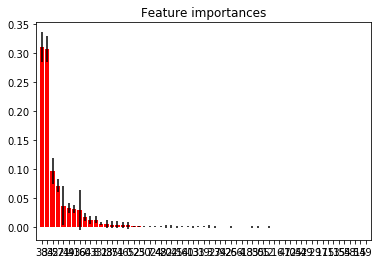

In [27]:
rfr = rfr_mean_decrease_impurity(X,y)
rfr_importance(rfr, X, y, df_stores_transactions)

### 3.1.2 random forest - mean decrease accuracy
直接度量每个特征对模型精确率的影响。主要思路是打乱每个特征的特征值顺序，并且度量顺序变动对模型的精确率的影响。很明显，对于不重要的变量来说，打乱顺序对模型的精确率影响不会太大，但是对于重要的变量来说，打乱顺序就会降低模型的精确率。

In [12]:
def rfr_mean_decrease_accuracy(X, y, df):
    rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
    scores = defaultdict(list)

    # crossvalidate the scores on a number of different random splits of the data
    for train_idx, test_idx in ShuffleSplit(len(X), 100, .3):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        r = rfr.fit(X_train, y_train)
        acc = r2_score(y_test, rfr.predict(X_test))
        for i in range(X.shape[1]):
            X_t = X_test.copy()
            np.random.shuffle(X_t[:, i])
            shuff_acc = r2_score(y_test, rfr.predict(X_t))
            scores[df_stores_transactions.columns[i]].append((acc-shuff_acc)/acc)
    return rfr

In [13]:
rfr = rfr_mean_decrease_accuracy(X, y, df_stores_transactions)
rfr_importance(rfr, X, y, df_stores_transactions)

KeyboardInterrupt: 

From above figure, we can select first 11 features.
1. feature 38 (0.310676) type_A
2. feature 34 (0.307727) state_Pichincha
3. feature 32 (0.096955) state_Manabi
4. feature 57 (0.071549) cluster_15
5. feature 21 (0.036588) city_Santo Domingo
6. feature 49 (0.033177) cluster_7
7. feature 41 (0.030693) type_D
8. feature 36 (0.029397) state_Santo Domingo de los Tsachilas
9. feature 60 (0.017457) transactions
10. feature 43 (0.012616) cluster_1
11. feature 8 (0.012273) city_Guayaquil

### Plot learning curve

In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(.05, 1., 20), verbose=0, plot=True):
    """
    Drawing learning curve
    ------------------------
    Parameter interpretation
    estimator : the classifier we use
    title : the title of chart
    X : input feature matrix. type: numpy
    y : input target vector
    ylim : setting the highest and lowest point in chart (ymin, ymax)
    cv : the total number of set we split into and one of them is testing set 
    n_jobs : the number of tasks process in parallel (default = 1)
    
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("training sample")
        plt.ylabel("score")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="training data")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label="testing data")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

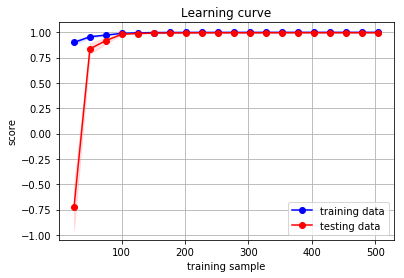

(0.99609457658504397, 0.0072488398028111023)

In [29]:
train_df = df_stores_transactions
train_np = train_df.as_matrix()

y = train_np[:,-1]
X = train_np[:,:-1]

plot_learning_curve(rfr, "Learning curve", X, y, cv = 5)

## 3.2 Items
### 3.2.1 family, class vs unit_sale

In [177]:
items_train = pd.merge(data.train, data.items, on='item_nbr', how='left')
items_train = items_train[['date','item_nbr','unit_sales','family','class','perishable']]
items_train

date  item_nbr  unit_sales        family  class  perishable
0 2013-01-01    103665         7.0  BREAD/BAKERY   2712           1
1 2013-01-01    105574         1.0     GROCERY I   1045           0
2 2013-01-01    105575         2.0     GROCERY I   1045           0
3 2013-01-01    108079         1.0     GROCERY I   1030           0
4 2013-01-01    108701         1.0          DELI   2644           1

In [180]:
data.train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 6 columns):
id             int64
date           datetime64[ns]
store_nbr      int8
item_nbr       int32
unit_sales     float32
onpromotion    int8
dtypes: datetime64[ns](1), float32(1), int32(1), int64(1), int8(2)
memory usage: 248.0 MB


In [178]:
items_train = items_train[['unit_sales','family','perishable']].head()
unit_sales_mean = items_train.groupby(['family'])['unit_sales'].mean()
unit_sales_std = items_train.groupby(['family'])['unit_sales'].std()
print(unit_sales_mean)
print(unit_sales_std)

family
BREAD/BAKERY    7.000000
DELI            1.000000
GROCERY I       1.333333
Name: unit_sales, dtype: float32
family
BREAD/BAKERY        NaN
DELI                NaN
GROCERY I       0.57735
Name: unit_sales, dtype: float32


In [43]:
items_train = data.merged_data[['date','item_nbr','unit_sales','family','class','perishable']]
items_unit_sales = pd.DataFrame({'item_nbr': unit_sales_mean.index.get_level_values('item_nbr'),
                      'family': unit_sales_mean.index.get_level_values('family'),
                      'class': unit_sales_mean.index.get_level_values('class'),
                      'unit_sales':unit_sales_mean.values})
items_unit_sales.head()

dummies_family = pd.get_dummies(items_unit_sales['family'], prefix='family')
dummies_class = pd.get_dummies(items_unit_sales['class'], prefix='class')
df_items_unit_sales = pd.concat([dummies_class,dummies_family,items_unit_sales['unit_sales']], axis = 1)

matrix_items_unit_sales = df_items_unit_sales.as_matrix()
   
y = matrix_items_unit_sales[:,-1]
X = matrix_items_unit_sales[:,:-1] 

Feature ranking:
1.feature 93 (0.186836) class_2416
2.feature 88 (0.087367) class_2302
3.feature 177 (0.062828) family_BEVERAGES
4.feature 8 (0.051017) class_1014
5.feature 119 (0.050405) class_2756
6.feature 145 (0.038694) class_3026
7.feature 43 (0.036984) class_1080
8.feature 39 (0.036595) class_1072
9.feature 193 (0.030801) family_POULTRY
10.feature 53 (0.027919) class_1124
11.feature 47 (0.026764) class_1088
12.feature 28 (0.023403) class_1045
13.feature 118 (0.018892) class_2752
14.feature 158 (0.018460) class_4114
15.feature 108 (0.017298) class_2702
16.feature 125 (0.016423) class_2904
17.feature 84 (0.016383) class_2226
18.feature 191 (0.015776) family_MEATS
19.feature 120 (0.014873) class_2784
20.feature 90 (0.012167) class_2306
21.feature 9 (0.011557) class_1016
22.feature 117 (0.011127) class_2750
23.feature 152 (0.011106) class_3038
24.feature 68 (0.009615) class_2102
25.feature 149 (0.008224) class_3032
26.feature 2 (0.008199) class_1004
27.feature 114 (0.008054) class_27

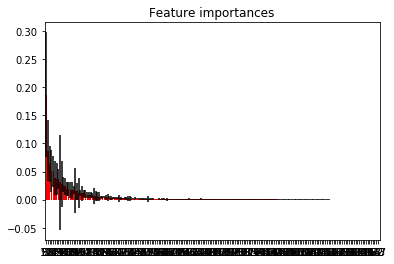

In [44]:
rfr = rfr_mean_decrease_impurity(X,y)
rfr_importance(rfr, X, y, df_items_unit_sales)

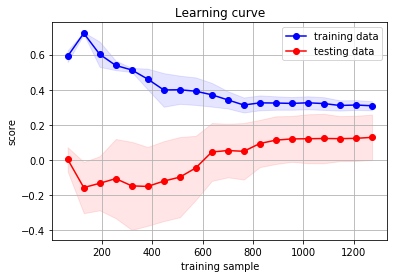

(0.16731177354735435, 0.33463646652959739)

In [45]:
train_df = df_items_unit_sales
train_np = train_df.as_matrix()

y = train_np[:,-1]
X = train_np[:,:-1]

plot_learning_curve(rfr, "Learning curve", X, y, cv = 5)

### 3.2.2 family vs unit_sale

In [174]:
# items_train = data.merged_data[['date','item_nbr','unit_sales','family','class','perishable']]
unit_sales_mean = items_train.groupby(['item_nbr','family','class'])['unit_sales'].mean()
items_unit_sales = pd.DataFrame({'item_nbr': unit_sales_mean.index.get_level_values('item_nbr'),
                      'family': unit_sales_mean.index.get_level_values('family'),
                      'class': unit_sales_mean.index.get_level_values('class'),
                      'unit_sales':unit_sales_mean.values})
items_unit_sales.head()

dummies_family = pd.get_dummies(items_unit_sales['family'], prefix='family')
df_items_unit_sales = pd.concat([dummies_family,items_unit_sales['unit_sales']], axis = 1)
matrix_items_unit_sales = df_items_unit_sales.as_matrix()
   
y = matrix_items_unit_sales[:,-1]
X = matrix_items_unit_sales[:,:-1] 

array([ 7.,  1.,  2.,  1.,  1.], dtype=float32)

Feature ranking:
1.feature 16 (0.353427) family_MEATS
2.feature 18 (0.299511) family_POULTRY
3.feature 2 (0.159767) family_BEVERAGES
4.feature 3 (0.073565) family_BREAD/BAKERY
5.feature 19 (0.033027) family_PREPARED FOODS
6.feature 14 (0.013664) family_LINGERIE
7.feature 0 (0.012955) family_AUTOMOTIVE
8.feature 9 (0.006563) family_GROCERY I
9.feature 4 (0.006517) family_CLEANING
10.feature 6 (0.006438) family_DELI
11.feature 8 (0.006033) family_FROZEN FOODS
12.feature 7 (0.005246) family_EGGS
13.feature 1 (0.004264) family_BEAUTY
14.feature 11 (0.003691) family_HARDWARE
15.feature 13 (0.002644) family_LAWN AND GARDEN
16.feature 17 (0.002605) family_PERSONAL CARE
17.feature 21 (0.002568) family_SEAFOOD
18.feature 5 (0.002201) family_DAIRY
19.feature 15 (0.001701) family_LIQUOR,WINE,BEER
20.feature 10 (0.001447) family_GROCERY II
21.feature 20 (0.001240) family_PRODUCE
22.feature 12 (0.000925) family_HOME APPLIANCES


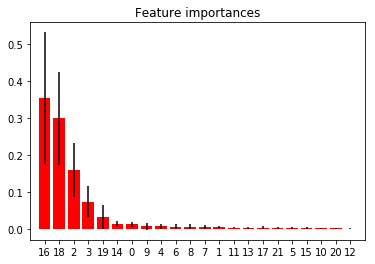

In [55]:
rfr = rfr_mean_decrease_impurity(X,y)
rfr_importance(rfr, X, y, df_items_unit_sales)

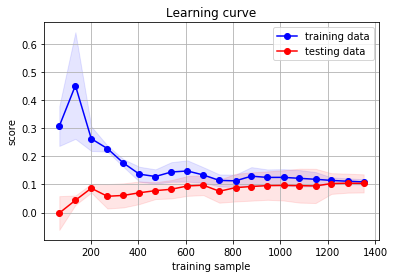

(0.095048301283975206, 0.046970545655864296)

In [56]:
train_df = df_items_unit_sales
train_np = train_df.as_matrix()

y = train_np[:,-1]
X = train_np[:,:-1]

plot_learning_curve(rfr, "Learning curve", X, y, cv = 5)

### 3.2.3 class vs unit_sale

In [59]:
items_train = data.merged_data[['date','item_nbr','unit_sales','family','class','perishable']]
unit_sales_mean = items_train.groupby(['item_nbr','family','class'])['unit_sales'].mean()
items_unit_sales = pd.DataFrame({'item_nbr': unit_sales_mean.index.get_level_values('item_nbr'),
                      'family': unit_sales_mean.index.get_level_values('family'),
                      'class': unit_sales_mean.index.get_level_values('class'),
                      'unit_sales':unit_sales_mean.values})
items_unit_sales.head()

dummies_class = pd.get_dummies(items_unit_sales['class'], prefix='class')
df_items_unit_sales = pd.concat([dummies_class,items_unit_sales['unit_sales']], axis = 1)
matrix_items_unit_sales = df_items_unit_sales.as_matrix()
   
y = matrix_items_unit_sales[:,-1]
X = matrix_items_unit_sales[:,:-1] 

Feature ranking:
1.feature 92 (0.248223) class_2302
2.feature 97 (0.154287) class_2416
3.feature 123 (0.061001) class_2756
4.feature 54 (0.046528) class_1124
5.feature 8 (0.044173) class_1014
6.feature 129 (0.038047) class_2904
7.feature 52 (0.036651) class_1120
8.feature 39 (0.028392) class_1072
9.feature 122 (0.023528) class_2752
10.feature 43 (0.022639) class_1080
11.feature 112 (0.018590) class_2702
12.feature 121 (0.017076) class_2750
13.feature 57 (0.016339) class_1136
14.feature 28 (0.015420) class_1045
15.feature 149 (0.013031) class_3026
16.feature 91 (0.012407) class_2246
17.feature 53 (0.012384) class_1122
18.feature 124 (0.010179) class_2784
19.feature 25 (0.010054) class_1040
20.feature 9 (0.009869) class_1016
21.feature 162 (0.009391) class_4114
22.feature 47 (0.009042) class_1088
23.feature 55 (0.008678) class_1126
24.feature 156 (0.008247) class_3038
25.feature 94 (0.007289) class_2306
26.feature 118 (0.006661) class_2718
27.feature 2 (0.006523) class_1004
28.feature 98

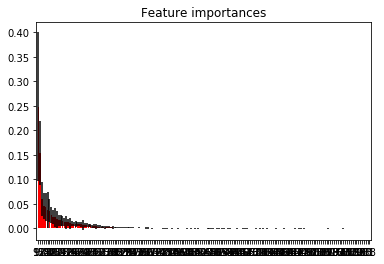

In [60]:
rfr = rfr_mean_decrease_impurity(X,y)
rfr_importance(rfr, X, y, df_items_unit_sales)

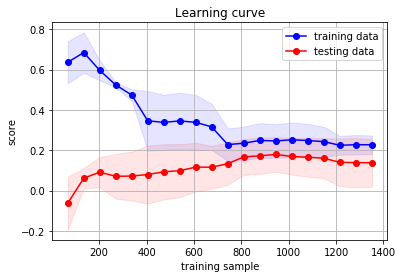

(0.14611785548115042, 0.25374861537462812)

In [61]:
train_df = df_items_unit_sales
train_np = train_df.as_matrix()

y = train_np[:,-1]
X = train_np[:,:-1]

plot_learning_curve(rfr, "Learning curve", X, y, cv = 5)